# __FINAL CHALLENGE__  

__Student:__ Imane SI SALAH (imane.si_salah@ens-paris-saclay.fr)
## __Introduction__
Deploying efficient and robust segmentation models is a necessity for a wide array of applications. This project undertakes the challenge of refining a segmentation model, specifically focusing on a UNet architecture, to enhance its deployment efficiency without significantly sacrificing accuracy.


Our approch start by an attempt to increase the performance of the original UNet model, by boing some data preprocessing and augmentation, label improvement, loss and postprocessing modifications. after that we compress the model using different stategies and obseve how the perfomance changes as we decrease the size of the model. Finally we implement knowledge distillation in order to increase the validation score of these small model.


In [ ]:
import os
import shutil
import time
import zipfile
import csv
from tqdm import tqdm
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from skimage import filters, io, img_as_float

from google.colab import drive

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
import  torch.optim   as optim

device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
HOME_PATH= '/content/drive/MyDrive/Geosciences/'
DATA_PATH= HOME_PATH+ 'data/'

data_dir = '/content/data/'
train_path= data_dir+'Train/'
val_path= data_dir+'Val/'
test_path=data_dir+'Test/'
batch_size= 128

In [ ]:
#extract nex data
data_dir = '/content/data/'

with zipfile.ZipFile(HOME_PATH+'data.zip', 'r') as zip_ref:
  zip_ref.extractall(data_dir)

In [ ]:
# define some helper funcitons
def plot(images, masks, pred_masks):
    """
    Plots the first example of the batch for the original image, the ground truth mask,
    and the predicted mask side by side.

    Parameters:
    - images (Tensor): The batch of images from the dataset.
    - masks (Tensor): The batch of true masks corresponding to the images.
    - pred_masks (Tensor): The batch of predicted masks produced by the model.

    Returns:
    - fig, axs (matplotlib.figure.Figure, array of Axes): The figure and axes objects of the plot.
    """
    images = images.data.cpu().numpy()
    masks = masks.data.cpu().numpy()
    pred_masks = pred_masks.data.cpu().numpy()
    fig, axs = plt.subplots(1, 3, figsize=(12, 7))
    axs[0].imshow(images[0].reshape(32, 32, -1))
    axs[0].set_title('Image')
    axs[1].imshow(masks[0].reshape(32, 32, -1))
    axs[1].set_title('Ground Truth Mask')
    axs[2].imshow(pred_masks[0].reshape(32, 32, -1))
    axs[2].set_title('Predicted Mask')
    return fig, axs

def dice_score(input, target, smooth=1.):
    """
    Calculates the Dice score, a measure of overlap between two samples.

    Parameters:
    - input (Tensor): Predicted masks.
    - target (Tensor): True masks.
    - smooth (float): A smoothing factor to avoid division by zero.

    Returns:
    - dice_score (float): The Dice score.
    """
    y_pred_proba =input.float()
    y_true = target.float()
    intersection = (y_pred_proba * y_true).sum(dim=(-1, -2, -3))
    y_true_flat = y_true.sum(dim=(-1, -2, -3))
    y_pred_flat = y_pred_proba.sum(dim=(-1, -2, -3))
    dice = (2. * intersection + smooth) / (y_pred_flat + y_true_flat + smooth)
    return dice.mean()

def dice_loss(input, target, smooth=1.):
    """
    Calculates the Dice loss, which is 1 minus the Dice score. This is used to minimize
    the difference between the predicted and true masks.

    Parameters:
    - input (Tensor): Predicted masks.
    - target (Tensor): True masks.
    - smooth (float): A smoothing factor to avoid division by zero.

    Returns:
    - dice_loss (float): The Dice loss.
    """
    if torch.sum(target)==0:
      dice=1
    else:
      dice = dice_score(input, target, smooth)
    return 1 - dice

def dice_bce_loss(input, target, smooth=1.):
    """
    Calculates a combined loss composed of the Dice loss and the Binary Cross-Entropy (BCE) loss.
    This can help leverage the advantages of both loss functions.

    Parameters:
    - input (Tensor): Predicted masks.
    - target (Tensor): True masks.
    - smooth (float): A smoothing factor to avoid division by zero.

    Returns:
    - combined_loss (float): The combined Dice and BCE loss.
    """
    dice = dice_loss(input, target, smooth)
    bce = F.binary_cross_entropy(input, target, reduction='mean')
    return dice + bce

def quantize_predictions(preds, levels=4):
    step = 1.0 / (levels - 1)
    quantized_preds = (preds / step).round() * step
    return quantized_preds


def visualize_weights(model, weights=False):
    cols = 4
    layer_idx = 0
    if not weights:
        num_layers = sum(1 for name, param in model.named_parameters() if "weight" in name)
        rows = -(-num_layers // cols)
        fig, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
        fig.suptitle('Weight Distributions Across Layers')
        for name, param in model.named_parameters():
            if "weight" in name:
                row, col = divmod(layer_idx, cols)
                weights = param.data.cpu().numpy().flatten()
                axs[row, col].hist(weights, bins=100, alpha=0.75)
                axs[row, col].set_title(name)
                axs[row, col].grid(True, linestyle='--', alpha=0.5)
                layer_idx += 1

        for idx in range(layer_idx, rows*cols):
            row, col = divmod(idx, cols)
            axs[row, col].axis('off')
    else:
        num_layers = len(model)
        rows = -(-num_layers // cols)
        fig, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
        fig.suptitle('Weight Distributions Across Layers')
        for name in model.keys():
            if 'weight' in name:
                row, col= divmod(layer_idx, cols)
                weights = model[name].cpu().numpy().flatten()
                axs[row, col].hist(weights, bins=100, alpha=0.75)
                axs[row, col].set_title(name)
                axs[row, col].grid(True, linestyle='--', alpha=0.5)
                layer_idx += 1
        for idx in range(layer_idx, rows*cols):
            row, col = divmod(idx, cols)
            axs[row, col].axis('off')


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()




def train_model(model, train_loader, val_loader, device, epochs=10, plot_interval=20, plot_=False):
    learning_rate = 1e-2
    criterion= nn.BCELoss()
    # criterion= dice_bce_loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


    train_losses = []
    val_losses = []
    train_scores = []
    val_scores = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_score = 0.0

        for i, (images, masks) in enumerate(train_loader):
            images = images.float().to(device)
            masks = masks.float().to(device)

            optimizer.zero_grad()
            pred_masks = model(images)
            loss = criterion(pred_masks, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            score = dice_score(pred_masks, masks)
            train_score += score.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_train_score = train_score / len(train_loader)
        train_losses.append(avg_train_loss)
        train_scores.append(avg_train_score)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_score = 0.0
        with torch.no_grad():
            for i, (images, masks) in enumerate(val_loader):
                images = images.float().to(device)
                masks = masks.float().to(device)

                pred_masks = model(images)
                loss = criterion(pred_masks, masks)
                pred_masks = (pred_masks >= 0.5).float()
                # pred_masks = quantize_predictions(pred_masks, levels=8)


                val_loss += loss.item()
                score = dice_score(pred_masks, masks)
                val_score += score.item()

                # Plot at given intervals
                if plot_ and i % plot_interval == 0:
                    plot(images.cpu(), masks.cpu(), pred_masks.cpu())
        avg_val_loss = val_loss / len(val_loader)
        avg_val_score = val_score / len(val_loader)
        val_losses.append(avg_val_loss)
        val_scores.append(avg_val_score)

        print(f'Epoch {epoch}/{epochs - 1}, Train Loss: {avg_train_loss}, Train Score: {avg_train_score}, Val Loss: {avg_val_loss}, Val Score: {avg_val_score}')

    return train_losses, val_losses, train_scores, val_scores



def test_model(model, loader, plot_=True, distillation=False):
    model.eval()
    val_score = 0.0
    with torch.no_grad():
        for i, (images, masks) in enumerate(tqdm(loader)):
            images = images.float().to(device)
            masks = masks.float().to(device)

            if not distillation:
              pred_masks = model(images)
            else:
              pred_masks,_ = model(images)
            pred_masks = (pred_masks >= 0.5).float()

            # pred_masks = quantize_predictions(pred_masks, levels=8)
            score = dice_score(pred_masks, masks)
            val_score += score.item()

            # Plot at given intervals
            if i % 10 == 0 and plot_:
                plot(images.cpu(), masks.cpu(), pred_masks.cpu())


    avg_val_score = val_score / len(loader)
    return avg_val_score

def smooth_labels(labels, sigma=1):
    """
    Apply Gaussian smoothing to the edges of binary masks.
    """
    smoothed_labels = np.zeros_like(labels, dtype=float)
    for i, label in enumerate(labels):
        smoothed_label = filters.gaussian(label, sigma=sigma, preserve_range=True)
        smoothed_labels[i] = smoothed_label
    return smoothed_labels

## __1. Model Consolidation__
### __a. Preprocessing__

Preprocessing involved several steps to ensure the model's input data was optimized for performance and accuracy. Notably, images containing NaN values were removed to maintain data integrity. Image values were clamped to a reasonable range to avoid outliers affecting the model's learning negatively. Furthermore, resizing the images to a 32x32 resolution was crucial to prevent errors during the upscaling phase in the U-Net architecture. These steps were foundational in preparing the data for effective model training.




In [ ]:
#for the teacher's dataset
class MyDataset2(torch.utils.data.Dataset):
    def __init__(self, path_to_data, transform=None, train=True, add_shift= None, smooth=False):
        self.path = path_to_data
        self.transform = transform
        self.train= train
        self.add_shift= add_shift
        self.smooth= smooth
        self.image_names = os.listdir(os.path.join(self.path, 'images'))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, i):
        image_name = self.image_names[i]
        image_path= os.path.join(self.path, 'images', image_name)
        label_path= os.path.join(self.path, 'labels', image_name)
        image = self.load_image(image_path)
        if self.train:
            label= self.load_image(label_path)
            if self.transform:
              image = self.transform(image)
              label= self.transform(label)
              label= (label >= 0.5)
            if self.add_shift:
              random_circ_shift_transform = RandomCircularHorizontalShift(max_h_shift_frac = self.add_shift)
              image, label = random_circ_shift_transform(image, label)
            if self.smooth:
              label = torch.from_numpy(smooth_labels(label.cpu().numpy()))

            return image, label
        else:
          if self.transform:
              image = self.transform(image)
          return image, image_name.split('.')[0]
    def load_image(self,path):
      img = torch.from_numpy(np.load(path)).unsqueeze(0).float()
      return img


class Filtered_Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, augmentation=None):
        self.augmentation= augmentation
        self.flt= [(img, label) for (img, label) in dataset if img is not torch.isnan(img).any()]

    def __len__(self):
        return len(self.flt)
    def __getitem__(self, i):
        image, label= self.flt[i]
        if self.augmentation:
          image= self.augmentation(image)
          label= self.augmentation(image)
        return image, label


class Filter_images(object):
    def __init__(self, range):
        self.min, self.max= range
    def __call__(self, image):
        # if torch.isnan(image).any():
        #     return None
        # else:
        image= torch.clamp(image, self.min, self.max)
        return image

class RandomCircularHorizontalShift:
    def __init__(self, max_h_shift_frac):
        """
        Args:
            max_h_shift_frac (float): Maximum horizontal shift as a fraction of image width.
        """
        self.max_h_shift_frac = max_h_shift_frac

    def __call__(self, image, mask):
        _, _, width = image.size()
        h_shift = np.random.uniform(-self.max_h_shift_frac, self.max_h_shift_frac) * width
        h_shift = int(h_shift)

        shifted_image = torch.roll(image, shifts=h_shift, dims=-1)
        shifted_mask = torch.roll(mask, shifts=h_shift, dims=-1)

        return shifted_image, shifted_mask


compose= transforms.Compose([
    transforms.Resize((32,32)), #resize the images to power of 2 to avoid errors in upsampling part
    Filter_images([-3, 3]), #large enough range
])

In [ ]:
train_set= MyDataset2(train_path, transform=compose)
train_set= Filtered_Dataset(train_set)

val_set= MyDataset2(val_path, transform=compose)
val_set= Filtered_Dataset(val_set)


# from torch.utils.data import  ConcatDataset
# print(len(train_set), len(val_set))
# full_dataset= ConcatDataset(datasets= [train_set, val_set])
# print(len(full_dataset))
# train_set, val_set= torch.utils.data.random_split(full_dataset, [0.81, 0.19])

train_loader= DataLoader(train_set, batch_size, shuffle=True, drop_last=True)
val_loader= DataLoader(val_set, batch_size, shuffle=True, drop_last=True)

test_set= MyDataset2(test_path, transform=compose, train=False)
test_set= Filtered_Dataset(test_set)
test_loader= DataLoader(test_set, batch_size, shuffle=False)

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.doubleConvLayer= nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU( inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
        )
    def forward(self, x):
        out= self.doubleConvLayer(x)
        return out

class DownSample(nn.Module):
    """ if input is [b_size, in_channels, h, w] returns out of size [b_size, out_channel, h/2, w/2]"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.doubleConvLayer= DoubleConv(in_channels, out_channels)
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, x):
        cov= self.doubleConvLayer(x)
        out= self.maxpool(cov)
        return cov, out

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample= nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.doubleConvLayer= DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1= self.upsample(x1)
        x= torch.cat([x1, x2],1) #concat the output of the downsampler
        x=self.doubleConvLayer(x)
        return x


class My_unet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # down sample layer
        self.downconv1= DownSample(in_channels, 64)
        self.downconv2= DownSample(64, 128)
        self.downconv3= DownSample(128, 256)
        self.downconv4= DownSample(256, 512)
        #conv layers in botelneck
        self.bottel= DoubleConv(512 , 1024)
        #upsample layers
        self.upconv1= UpSample(1024, 512)
        self.upconv2= UpSample(512, 256)
        self.upconv3= UpSample(256, 128)
        self.upconv4= UpSample(128, 64)
        #last conv layer
        self.out = nn.Conv2d(in_channels= 64, out_channels=out_channels, kernel_size=1)
        self.sigmoid= nn.Sigmoid()
    def forward(self, x, T=1.):
        cov1, down1 = self.downconv1(x)
        cov2, down2 = self.downconv2(down1)
        cov3, down3 = self.downconv3(down2)
        cov4, down4 = self.downconv4(down3)
        bottleneck = self.bottel(down4)
        up1 = self.upconv1(bottleneck, cov4)
        up2 = self.upconv2(up1, cov3)
        up3 = self.upconv3(up2, cov2)
        up4 = self.upconv4(up3, cov1)
        out = self.sigmoid(self.out(up4))
        # out= self.out(up4)
        return out, self.sigmoid(self.out(up4)/T)


In [ ]:
model=My_unet(1,1)
state= torch.load('/content/drive/MyDrive/Geosciences/save/models/trained_unet_84.pth') #map_location=torch.device('cpu')
model.load_state_dict(state, strict= False)
model= model.to(device)

100%|██████████| 19/19 [00:01<00:00, 16.73it/s]


 Val Score: 0.92409369506334


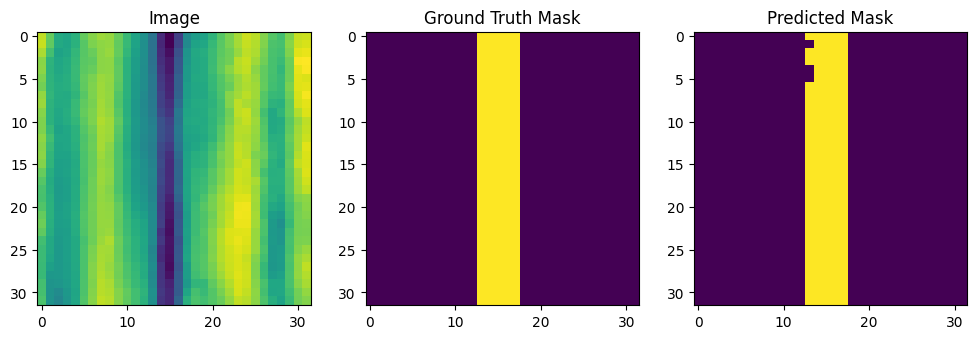

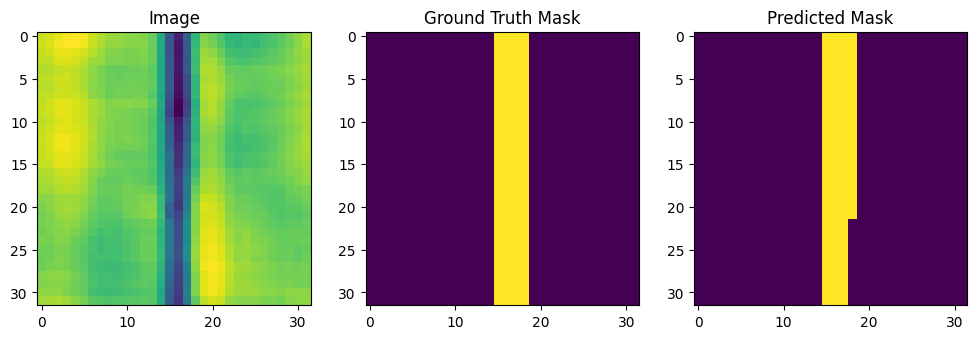

In [ ]:
avg_val_score = test_model(model, val_loader)
print(f' Val Score: {avg_val_score}')


### __b.	Augmentation__

The augmentation strategy included implementing circular shifts. However, it was observed that this technique marginally reduced the validation score of the model. This unexpected outcome highlighted the importance of selecting augmentation methods that align closely with the model's learning patterns and the data's inherent characteristics.


c.	Hyperparameter tuning \\
d.	Label improvement using image processing techniques using skimage package or segment anything.\\
e.	Change of the loss (constraint), postprocessing (continuity of the patches)\\
Please monitor your improvements to clearly see the additional value of each change.


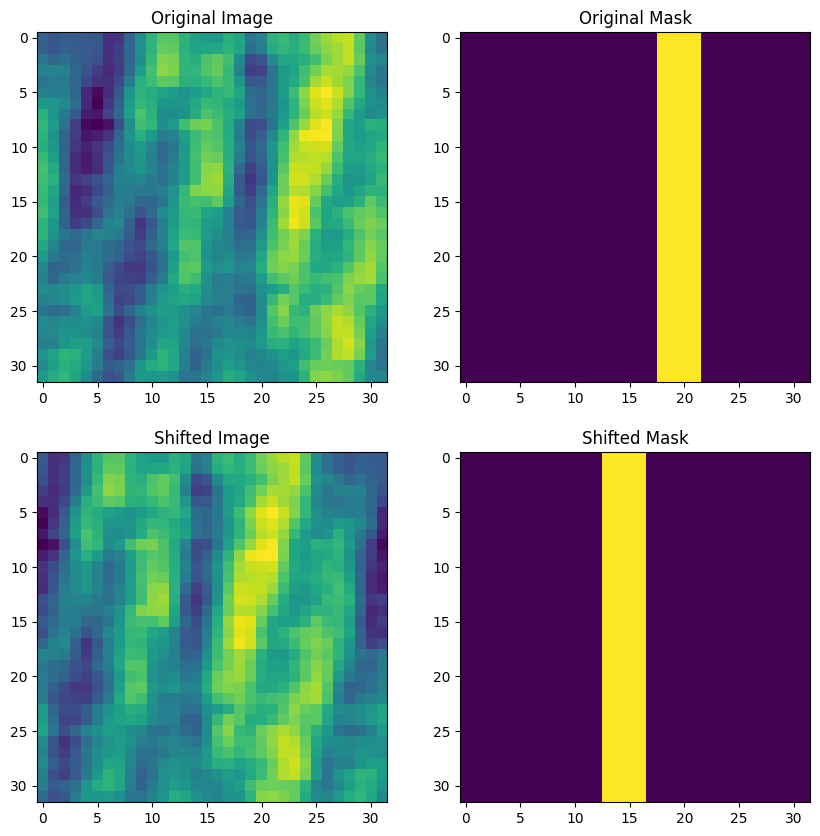

In [ ]:
# circular shifts
class RandomCircularHorizontalShift:
    def __init__(self, max_h_shift_frac):
        """
        Args:
            max_h_shift_frac (float): Maximum horizontal shift as a fraction of image width.
        """
        self.max_h_shift_frac = max_h_shift_frac

    def __call__(self, image, mask):
        _, _, width = image.size()
        h_shift = np.random.uniform(-self.max_h_shift_frac, self.max_h_shift_frac) * width
        h_shift = int(h_shift)

        # Apply circular horizontal shift
        shifted_image = torch.roll(image, shifts=h_shift, dims=-1)
        shifted_mask = torch.roll(mask, shifts=h_shift, dims=-1)

        return shifted_image, shifted_mask


#test the shift transform
for image, label in train_set:
    random_circ_shift_transform = RandomCircularHorizontalShift(max_h_shift_frac=0.3)
    shifted_image, shifted_mask = random_circ_shift_transform(image, label)
    break

# Visualize the results
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(image.permute(1, 2, 0))
ax[0, 0].set_title("Original Image")
ax[0, 1].imshow(label.squeeze())
ax[0, 1].set_title("Original Mask")
ax[1, 0].imshow(shifted_image.permute(1, 2, 0))
ax[1, 0].set_title("Shifted Image")
ax[1, 1].imshow(shifted_mask.squeeze())
ax[1, 1].set_title("Shifted Mask")
plt.show()

In [ ]:
train_set= MyDataset2(train_path, transform=compose, add_shift= 0.3)
train_set= Filtered_Dataset(train_set, )

val_set= MyDataset2(val_path, transform=compose, add_shift= 0.3)
val_set= Filtered_Dataset(val_set)

train_loader= DataLoader(train_set, batch_size, shuffle=True, drop_last=True)
val_loader= DataLoader(val_set, batch_size, shuffle=True, drop_last=True)


In [ ]:
train_losses, val_losses, train_scores, val_scores = train_model(model, train_loader, val_loader, device)

Epoch 0/9, Train Loss: 0.08401322444634778, Train Score: 0.7699621745518276, Val Loss: 0.4423300121959887, Val Score: 0.8669793637175309
Epoch 1/9, Train Loss: 0.06815459659057004, Train Score: 0.8116106912493706, Val Loss: 0.34664419136549296, Val Score: 0.880096551619078
Epoch 2/9, Train Loss: 0.06122211440067206, Train Score: 0.8315284411822047, Val Loss: 0.7508288182710346, Val Score: 0.8626955465266579
Epoch 3/9, Train Loss: 0.0561084366137428, Train Score: 0.8462908161537988, Val Loss: 0.7428083921733656, Val Score: 0.8579181213127939
Epoch 4/9, Train Loss: 0.052034244406968355, Train Score: 0.8584464234965188, Val Loss: 0.6242000586108157, Val Score: 0.8800876046481886
Epoch 5/9, Train Loss: 0.04920126983363714, Train Score: 0.8675318903156689, Val Loss: 0.8616556399746945, Val Score: 0.8546567559242249
Epoch 6/9, Train Loss: 0.04527489209015455, Train Score: 0.8788865336350032, Val Loss: 0.9119577031386527, Val Score: 0.8625571539527491
Epoch 7/9, Train Loss: 0.0436322748261903

100%|██████████| 19/19 [00:01<00:00, 15.04it/s]


 Val Score: 0.9336638607476887


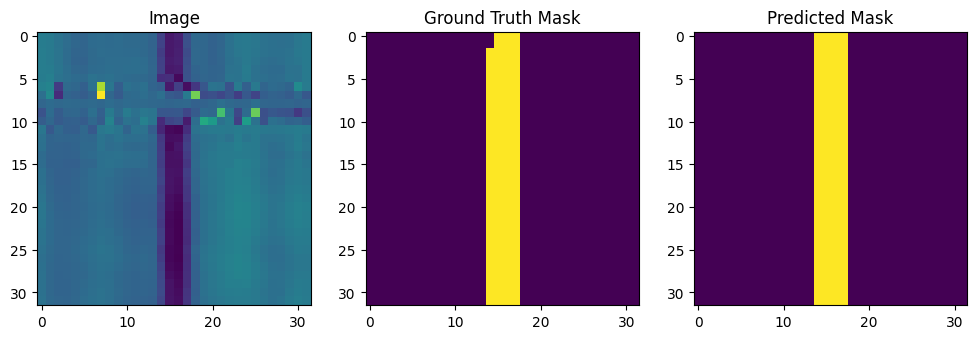

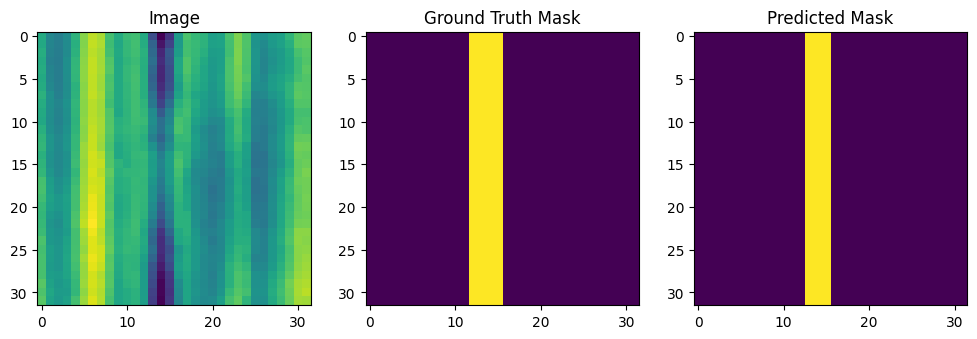

In [ ]:
avg_val_score = test_model(model, val_loader)
print(f' Val Score: {avg_val_score}')

### __c. Label Improvement__
To enhance the quality of the labels, label smoothing was employed.it  proved to be particularly effective in improving model performance by softening the edges of the labels, which was more beneficial than the augmentation efforts. Attempts were made to integrate the 'segment anything' model for further improvement, but implementation challenges prevented its successful application.

In [ ]:
import torch.nn.functional as F

def smooth_labels(labels, sigma=1):
    """
    Apply Gaussian smoothing to the edges of binary masks.

    Parameters:
    - labels: numpy array of binary masks.
    - sigma: Standard deviation for Gaussian kernel.

    Returns:
    - smoothed_labels: numpy array of smoothed binary masks.
    """
    smoothed_labels = np.zeros_like(labels, dtype=float)
    for i, label in enumerate(labels):
        smoothed_label = filters.gaussian(label, sigma=sigma, preserve_range=True)
        smoothed_labels[i] = smoothed_label
    return smoothed_labels



In [ ]:
train_set= MyDataset2(train_path, transform=compose, add_shift= None, smooth=True)
train_set= Filtered_Dataset(train_set, )

val_set= MyDataset2(val_path, transform=compose, add_shift= None, smooth=True)

val_set= Filtered_Dataset(val_set)

train_loader= DataLoader(train_set, batch_size, shuffle=True, drop_last=True)
val_loader= DataLoader(val_set, batch_size, shuffle=True, drop_last=True)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


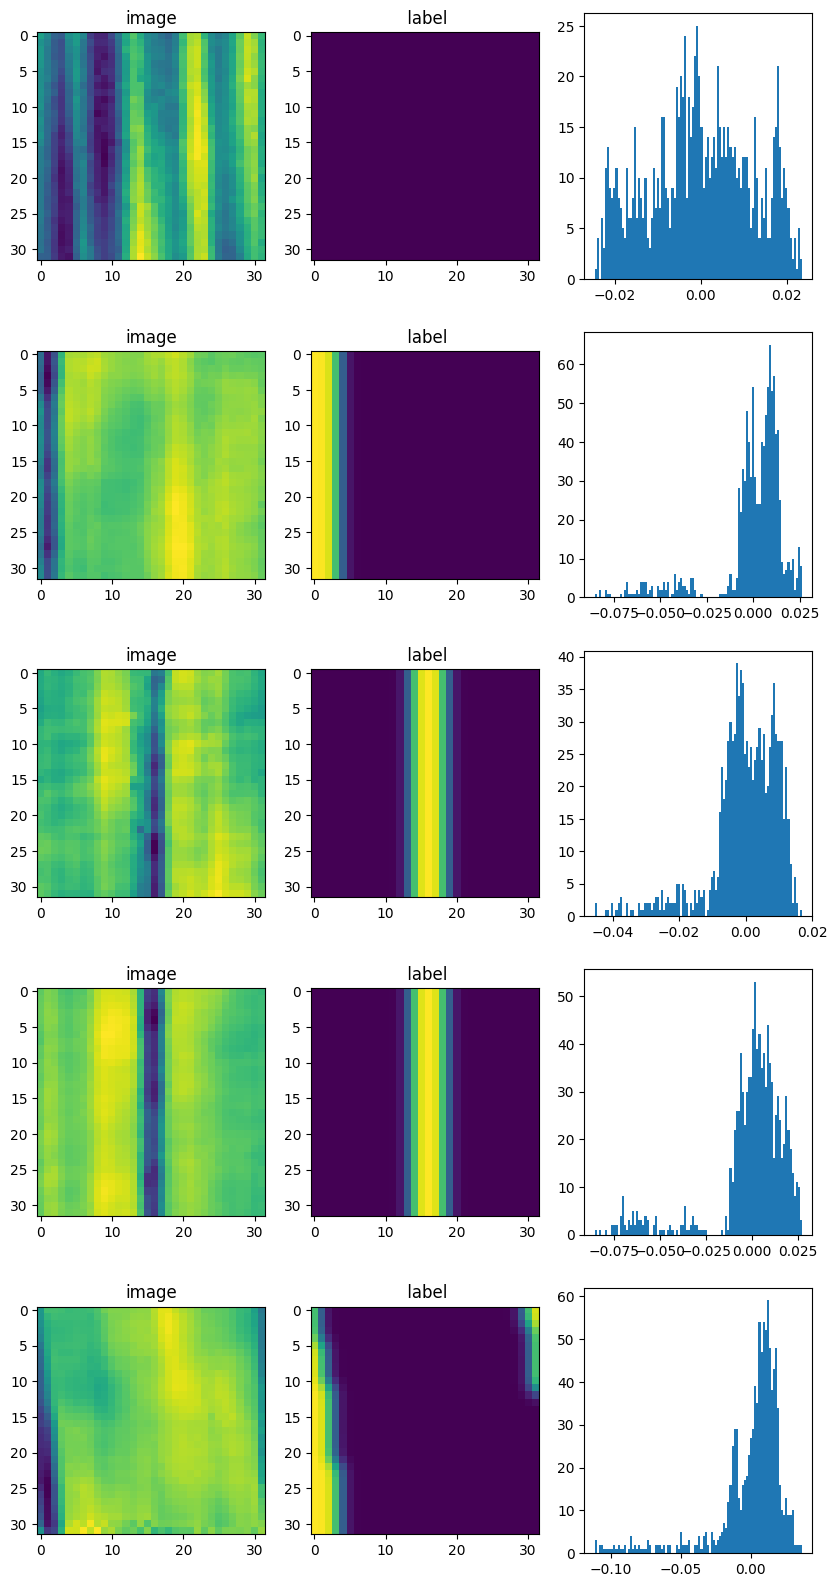

In [ ]:
fig, axes = plt.subplots(5, 3, figsize=(10, 20))

for i, (img, label) in enumerate(val_set):

    img_flat = img.flatten()

    axes[i, 0].imshow(img.squeeze())
    axes[i, 0].set_title('image')

    axes[i, 1].imshow(label.squeeze())
    axes[i, 1].set_title(' label')

    axes[i, 2].hist(img_flat, bins=100)

    if i==4:
      break
plt.show()

In [ ]:
train_losses, val_losses, train_scores, val_scores = train_model(model, train_loader, val_loader, device)

Epoch 0/9, Train Loss: 0.08709707164338656, Train Score: 0.9376861527562141, Val Loss: 0.4710467661681928, Val Score: 0.9633587253721136
Epoch 1/9, Train Loss: 0.08063720951655082, Train Score: 0.9552913861615318, Val Loss: 0.45992279209588705, Val Score: 0.969950867326636
Epoch 2/9, Train Loss: 0.0790729256612914, Train Score: 0.9608755984476635, Val Loss: 0.5090308534471613, Val Score: 0.9631160372181943
Epoch 3/9, Train Loss: 0.07809045391955546, Train Score: 0.9642328673175403, Val Loss: 0.48463057059990733, Val Score: 0.9703212443150973
Epoch 4/9, Train Loss: 0.07599217923624176, Train Score: 0.9719391550336566, Val Loss: 0.4464246818893834, Val Score: 0.9719543519772982
Epoch 5/9, Train Loss: 0.0753189113789371, Train Score: 0.9749791366713387, Val Loss: 0.48765290254040766, Val Score: 0.9710334037479601
Epoch 6/9, Train Loss: 0.07523007305072886, Train Score: 0.9753672704100609, Val Loss: 0.47194657200261164, Val Score: 0.9729861272008795
Epoch 7/9, Train Loss: 0.074677338823676

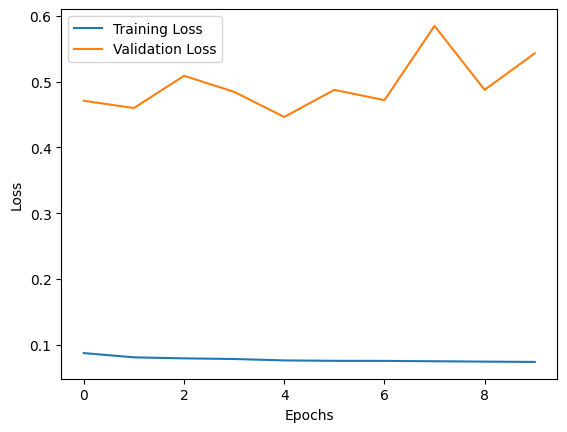

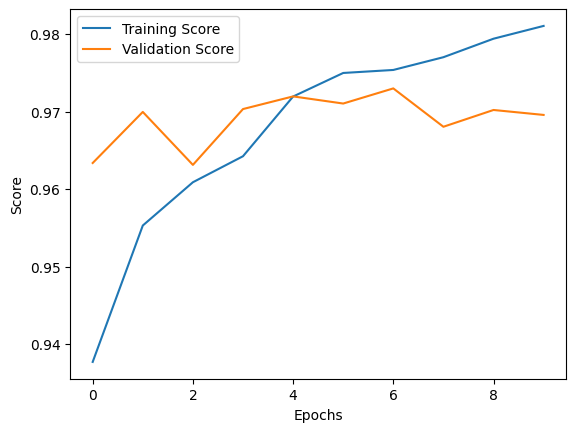

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Similarly for the scores:
plt.plot(train_scores, label='Training Score')
plt.plot(val_scores, label='Validation Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()

100%|██████████| 19/19 [00:01<00:00, 13.84it/s]


 Val Score: 0.9025448090151736


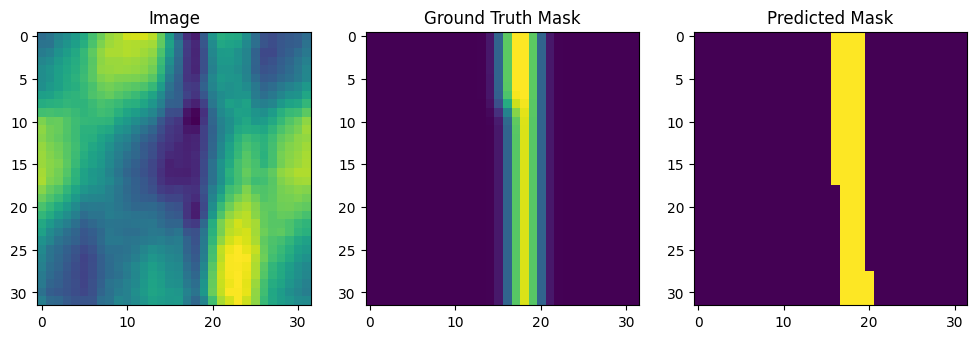

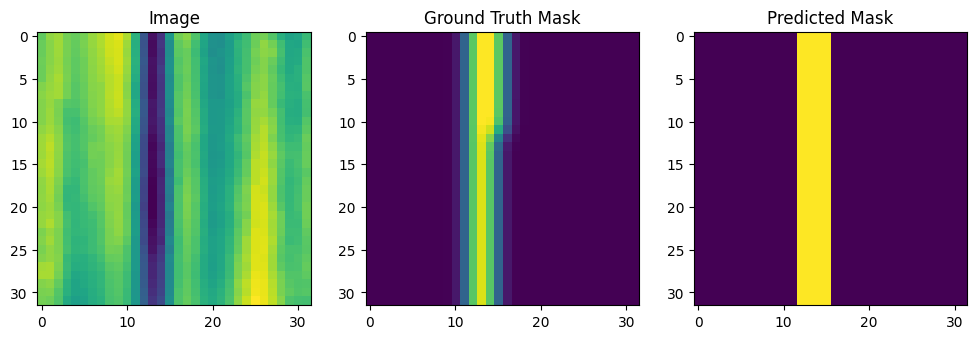

In [ ]:
avg_val_score = test_model(model, val_loader)
print(f' Val Score: {avg_val_score}')

here we apply both augmentation adn label smoothing

In [ ]:
# try out both:
train_set= MyDataset2(train_path, transform=compose, add_shift= 0.3, smooth=True)
train_set= Filtered_Dataset(train_set, )

val_set= MyDataset2(val_path, transform=compose, add_shift= 0.3, smooth=True)
val_set= Filtered_Dataset(val_set)

train_loader= DataLoader(train_set, batch_size, shuffle=True, drop_last=True)
val_loader= DataLoader(val_set, batch_size, shuffle=True, drop_last=True)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
train_losses, val_losses, train_scores, val_scores = train_model(model, train_loader, val_loader, device)

Epoch 0/9, Train Loss: 0.1171395710802504, Train Score: 0.8192524888685772, Val Loss: 0.6225045480226216, Val Score: 0.9093448049143741
Epoch 1/9, Train Loss: 0.10333285587174552, Train Score: 0.8657914772629738, Val Loss: 0.5359627275090468, Val Score: 0.9314260106337698
Epoch 2/9, Train Loss: 0.09778936353645154, Train Score: 0.88755373443876, Val Loss: 0.6616008187595167, Val Score: 0.9240114312422903
Epoch 3/9, Train Loss: 0.09447596474949803, Train Score: 0.9015895404985973, Val Loss: 0.6806875969234266, Val Score: 0.9325139334327296
Epoch 4/9, Train Loss: 0.09132963272609881, Train Score: 0.9130554784621511, Val Loss: 0.8734443030859295, Val Score: 0.906036376953125
Epoch 5/9, Train Loss: 0.0906276854553393, Train Score: 0.9159788319042751, Val Loss: 0.7904435756959414, Val Score: 0.9147429278022364
Epoch 6/9, Train Loss: 0.08838267943688802, Train Score: 0.9251463743192809, Val Loss: 1.0372923549852873, Val Score: 0.9012307618793688
Epoch 7/9, Train Loss: 0.08600732271692582, Tr

100%|██████████| 19/19 [00:01<00:00, 13.85it/s]


 Val Score: 0.8182379822981986


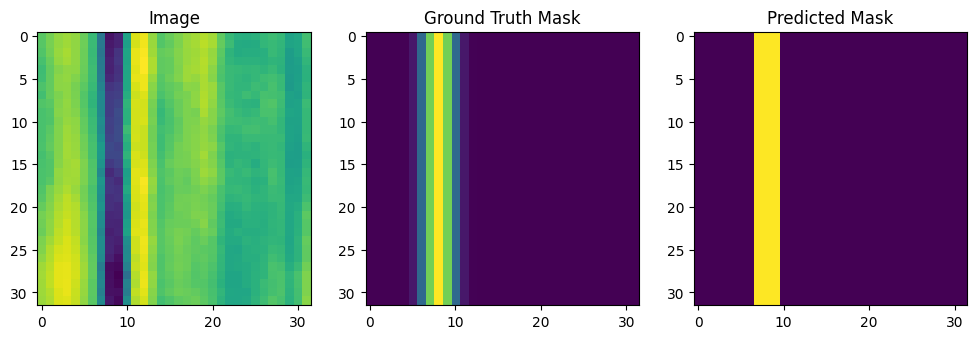

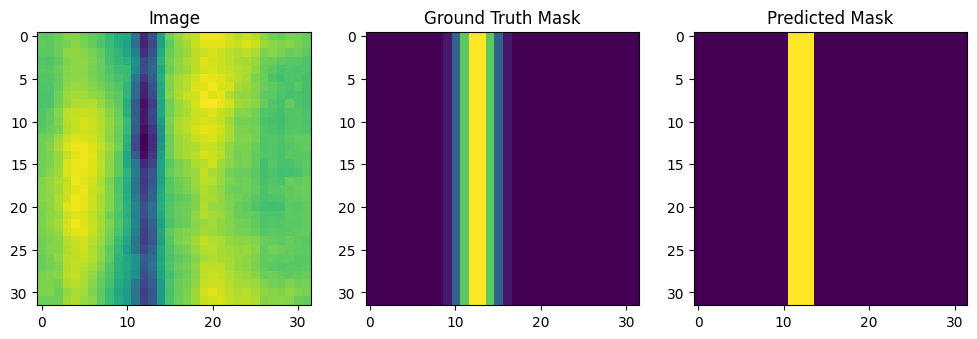

In [ ]:
avg_val_score = test_model(model, val_loader)
print(f' Val Score: {avg_val_score}')

## __2. Model Compression via Knowledge Distillation:__


Several smaller versions of the U-Net model were designed to evaluate the efficacy of __model compression__:

* model with a reduced number of downsampling and upsampling blocks.
* model with fewer kernels.
* combined approach with reduced layers and kernels.

Afetr that __Knowledge Distillation__ was implemented on each model, this step was pivotal to retreive a a bit of the lost perfomance of the model due to compression, we test for 4 values of the temperature parameter.The temperature parameter tunes the softness of the output distributions. Adjusting this parameter demonstrated the delicate balance required to effectively transfer knowledge to smaller models.

######### __Reduced model 1__: Reduce the number of layers only  #########


In this part we attempt to reduce the memory usage of the model by reducing the number of layers on the Unet, in fact we only leave 2 DownSamplign blocks and their opposite Upsampling blocks with the same kernel configuration as the original Unet, we train this reduced model, analyse its perfomance compared to the originil, observe its momory usage then we apply knowledge distillation to attemps to increase its performance taking the original Unet as teacher

In [ ]:
# Reduce layers UNET
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.doubleConvLayer= nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU( inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
        )
    def forward(self, x):
        out= self.doubleConvLayer(x)
        return out

class DownSample(nn.Module):
    """ if input is [b_size, in_channels, h, w] returns out of size [b_size, out_channel, h/2, w/2]"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.doubleConvLayer= DoubleConv(in_channels, out_channels)
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, x):
        cov= self.doubleConvLayer(x)
        out= self.maxpool(cov)
        return cov, out

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample= nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.doubleConvLayer= DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1= self.upsample(x1)
        x= torch.cat([x1, x2],1) #concat the output of the downsampler
        x=self.doubleConvLayer(x)
        return x


class My_unet2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # down sample layer
        self.downconv1= DownSample(in_channels, 64)
        self.downconv2= DownSample(64, 128)
        #conv layers in botelneck
        self.bottel= DoubleConv(128 , 256)
        #upsample layers
        self.upconv1= UpSample(256, 128)
        self.upconv2= UpSample(128, 64)
        #last conv layer
        self.out = nn.Conv2d(in_channels= 64, out_channels=out_channels, kernel_size=1)
        self.sigmoid= nn.Sigmoid()
    def forward(self, x, T=1.0):
        cov1, down1 = self.downconv1(x)
        cov2, down2 = self.downconv2(down1)
        bottleneck = self.bottel(down2)
        up1 = self.upconv1(bottleneck, cov2)
        up2 = self.upconv2(up1, cov1)
        out = self.sigmoid(self.out(up2)/T)
        return out


In [ ]:
model2= My_unet2(1,1).to(device)
train_losses, val_losses, train_scores, val_scores = train_model(model2, train_loader, val_loader, device, epochs= 40)

Epoch 0/39, Train Loss: 0.2488425980721201, Train Score: 0.20929849347365753, Val Loss: 0.4804935596491161, Val Score: 0.007434209894486948
Epoch 1/39, Train Loss: 0.1504847706694688, Train Score: 0.5101482804332461, Val Loss: 0.11931256518552177, Val Score: 0.7294459625294334
Epoch 2/39, Train Loss: 0.11137372561331306, Train Score: 0.6776885315775871, Val Loss: 0.1350503199194607, Val Score: 0.6363635345509178
Epoch 3/39, Train Loss: 0.09511798873011555, Train Score: 0.731526509991714, Val Loss: 0.19466142042687065, Val Score: 0.5828875648347955
Epoch 4/39, Train Loss: 0.09002992470881768, Train Score: 0.7462756239942142, Val Loss: 0.10201462005314074, Val Score: 0.7704609036445618
Epoch 5/39, Train Loss: 0.08347239225570645, Train Score: 0.7650416057024684, Val Loss: 0.09120440679161172, Val Score: 0.7927174662288866
Epoch 6/39, Train Loss: 0.08038802923900741, Train Score: 0.7747173245464053, Val Loss: 0.10279717296361923, Val Score: 0.7770055375601116
Epoch 7/39, Train Loss: 0.074

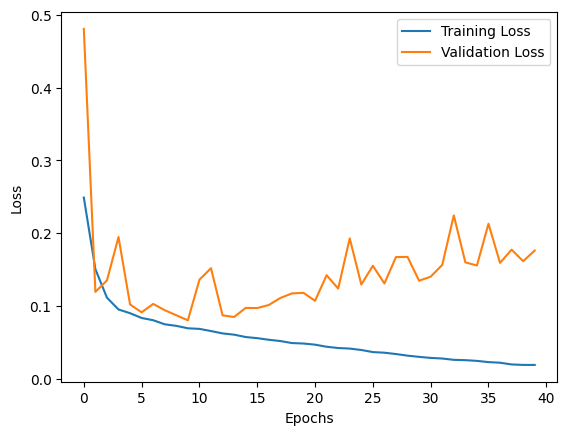

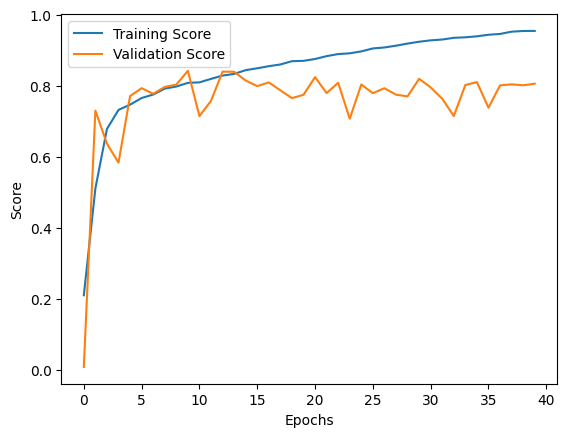

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Similarly for the scores:
plt.plot(train_scores, label='Training Score')
plt.plot(val_scores, label='Validation Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()

In [ ]:
#save model
save_path= '/content/drive/MyDrive/Geosciences/save/models/trained_unet_2layers_80.pth'
torch.save(model2.state_dict(), save_path)


In [ ]:
reduced_size = os.path.getsize('/content/drive/MyDrive/Geosciences/save/models/trained_unet_2layers_80.pth')
print(f"2layers Unet Model Size: {reduced_size / (1024 * 1024):.2f} MB")

2layers Unet Model Size: 7.13 MB


we see that in fact he model's size in reduced from 118.45MB to __7.13 MB__, and the validation score dropped to 80%

In [ ]:
def distillation(teacher, student, train_loader, epochs, lr, T, soft_loss_weight, bce_loss_weight, device, disp= True):
    bce_loss = nn.BCELoss()
    optimizer = optim.Adam(student.parameters(), lr=lr)
    teacher.eval()
    student.train()

    for epoch in tqdm(range(epochs), desc=f'distillation T= {T}'):
            running_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device).float()

                optimizer.zero_grad()

                with torch.no_grad():
                    teacher_out, teacher_out_T = teacher(images)

                student_out, student_out_T = student(images)


                student_out_hard=  (student_out >= 0.5).float()
                # distillation_loss = F.kl_div(F.sigmoid(teacher_out), F.sigmoid(student_out), reduction='batchmean') * (T ** 2)
                # distillation_loss = torch.sum(teacher_out * (teacher_out.log() - student_out)) / student_out.size()[0] * (T**2)
                distillation_loss= bce_loss(student_out_T,  teacher_out_T)
                hard_loss = bce_loss(student_out, labels)
                loss = soft_loss_weight * distillation_loss + bce_loss_weight * hard_loss

                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            avg_training_loss = running_loss / len(train_loader)
            student.eval()
            val_loss = 0.0
            val_score = 0.0
            with torch.no_grad():
                for i, (images, masks) in enumerate(val_loader):
                    images = images.float().to(device)
                    masks = masks.float().to(device)

                    pred_masks = student(images)
                    pred_masks = (pred_masks[0] >= 0.5).float()
                    score = dice_score(pred_masks[0], masks)
                    val_score += score.item()

            avg_val_score = val_score / len(val_loader)
            if disp:
                print(f'Epoch {epoch}, Training Loss: {avg_training_loss:.4f}, Validation Loss: , Validation Score: {avg_val_score:.4f}') #{avg_val_loss:.4f}

            student.train()

In [ ]:
teacher=My_unet(1,1)
state= torch.load('/content/drive/MyDrive/Geosciences/save/models/trained_unet_84.pth') #map_location=torch.device('cpu')
teacher.load_state_dict(state)
teacher= teacher.to(device)


student= My_unet2(1,1)
state_student= torch.load('/content/drive/MyDrive/Geosciences/save/models/trained_unet_2layers_80.pth')
student.load_state_dict(state_student)
student= student.to(device)

100%|██████████| 19/19 [00:00<00:00, 46.34it/s]


Student score before distillation: 0.7625432579140914


100%|██████████| 19/19 [00:00<00:00, 43.46it/s]


Temperature: 1, Validation Score: 0.7736810979090238


100%|██████████| 19/19 [00:00<00:00, 36.56it/s]


Temperature: 2, Validation Score: 0.6903837229076185


100%|██████████| 19/19 [00:00<00:00, 43.89it/s]


Temperature: 5, Validation Score: 0.7170703944407011


100%|██████████| 19/19 [00:00<00:00, 44.28it/s]


Temperature: 10, Validation Score: 0.7306506037712097


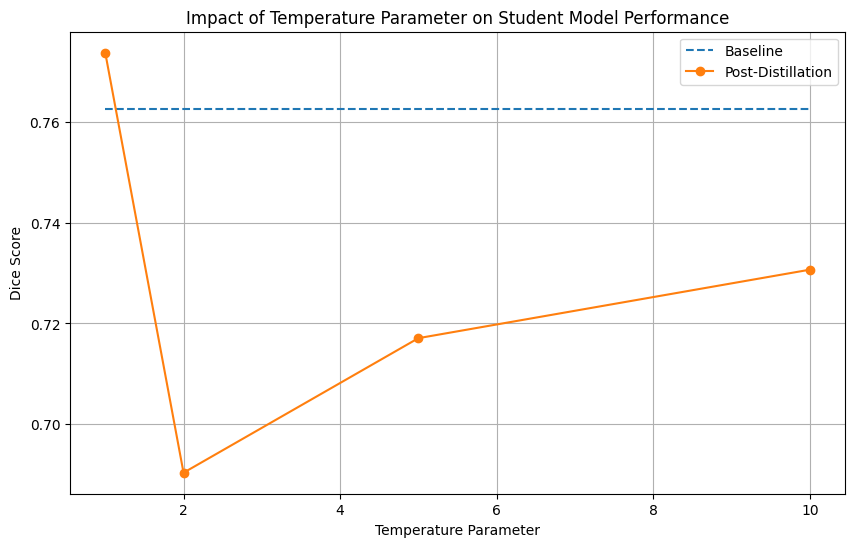

In [ ]:
import copy


baseline_score = test_model(student, val_loader, plot_=False)
print('Student score before distillation:', baseline_score)

temperature_params = [1, 2, 5, 10]
post_distillation_scores = []

for T in temperature_params:
    # Copy the original student model to preserve its pre-distilled state
    student_copy = copy.deepcopy(student)

    # Perform distillation
    distillation(teacher, student_copy, train_loader, epochs=20, lr=0.01, T=T, soft_loss_weight=0.25, bce_loss_weight=0.75, device=device, disp= False)

    # Post-distillation evaluation
    score = test_model(student_copy, val_loader, plot_=False)
    post_distillation_scores.append(score)

    print(f"Temperature: {T}, Validation Score: {score}")

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(temperature_params, [baseline_score] * len(temperature_params), label='Baseline', linestyle='--')
plt.plot(temperature_params, post_distillation_scores, label='Post-Distillation', marker='o')
plt.xlabel('Temperature Parameter')
plt.ylabel('Dice Score')
plt.title('Impact of Temperature Parameter on Student Model Performance')
plt.legend()
plt.grid(True)
plt.show()


in this part distillation was implemented to attempt to increase lost model performance due to reducing number of layers, we see that the perfomance was not improved a lot and that the incresing the temperature parameter does not really improve the validaiton score of the model

######### __Reduced model 2__: Reduce the number of kernels and layers  #########

In [ ]:
# reduce kernels and layers unet

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.doubleConvLayer= nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU( inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
        )
    def forward(self, x):
        out= self.doubleConvLayer(x)
        return out

class DownSample(nn.Module):
    """ if input is [b_size, in_channels, h, w] returns out of size [b_size, out_channel, h/2, w/2]"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.doubleConvLayer= DoubleConv(in_channels, out_channels)
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, x):
        cov= self.doubleConvLayer(x)
        out= self.maxpool(cov)
        return cov, out

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample= nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.doubleConvLayer= DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1= self.upsample(x1)
        x= torch.cat([x1, x2],1) #concat the output of the downsampler
        x=self.doubleConvLayer(x)
        return x

class My_unet3(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # down sample layer
        self.downconv1= DownSample(in_channels, 16)
        self.downconv2= DownSample(16, 32)
        #conv layers in botelneck
        self.bottel= DoubleConv(32 , 64)
        #upsample layers
        self.upconv1= UpSample(64, 32)
        self.upconv2= UpSample(32, 16)
        #last conv layer
        self.out = nn.Conv2d(in_channels= 16, out_channels=out_channels, kernel_size=1)
        self.sigmoid= nn.Sigmoid()
    def forward(self, x, T=1.):
        cov1, down1 = self.downconv1(x)
        cov2, down2 = self.downconv2(down1)
        bottleneck = self.bottel(down2)
        up1 = self.upconv1(bottleneck, cov2)
        up2 = self.upconv2(up1, cov1)
        out = self.sigmoid(self.out(up2)/T)
        # out = self.out(up2)
        return out

In [ ]:
model3= My_unet3(1,1).to(device)


In [ ]:
train_losses, val_losses, train_scores, val_scores = train_model(model3, train_loader, val_loader, device, epochs= 50)

Epoch 0/49, Train Loss: 0.24466395484549658, Train Score: 0.16038046923599072, Val Loss: 10.27326081928454, Val Score: 0.1244499197131709
Epoch 1/49, Train Loss: 0.12622718712581055, Train Score: 0.32685995660722256, Val Loss: 5.482282136615954, Val Score: 0.6530218093018783
Epoch 2/49, Train Loss: 0.1029723547399044, Train Score: 0.43019188780869755, Val Loss: 4.409227873149671, Val Score: 0.7307563518223009
Epoch 3/49, Train Loss: 0.0918267433132444, Train Score: 0.46869466294135365, Val Loss: 3.8531253212376644, Val Score: 0.7588200537781966
Epoch 4/49, Train Loss: 0.08633581655366081, Train Score: 0.48809065244027544, Val Loss: 4.14786087839227, Val Score: 0.7445612392927471
Epoch 5/49, Train Loss: 0.08269568971757378, Train Score: 0.4985579513013363, Val Loss: 3.5707975688733553, Val Score: 0.7753448988261976
Epoch 6/49, Train Loss: 0.07897529498274837, Train Score: 0.5123053837035384, Val Loss: 4.3636924342105265, Val Score: 0.7314650855566326
Epoch 7/49, Train Loss: 0.0769985328

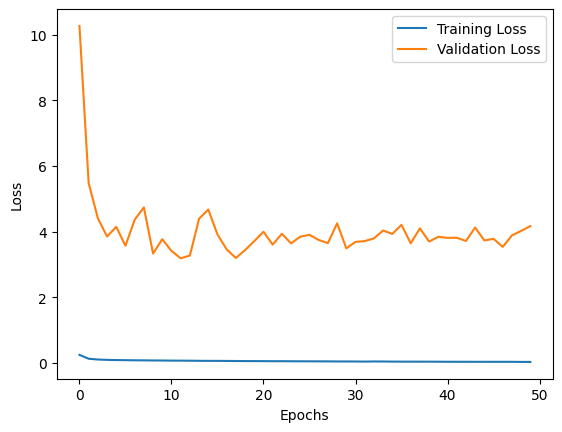

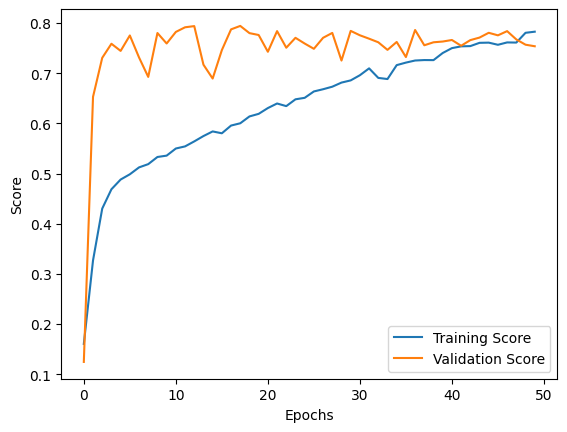

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Similarly for the scores:
plt.plot(train_scores, label='Training Score')
plt.plot(val_scores, label='Validation Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()

In [ ]:
#save model
save_path= '/content/drive/MyDrive/Geosciences/save/models/trained_unet_2layers_small_kernels.pth'
torch.save(model3.state_dict(), save_path)

In [ ]:
reduced_size = os.path.getsize('/content/drive/MyDrive/Geosciences/save/models/trained_unet_2layers_small_kernels.pth')
print(f"2layers + reduced kernerls Unet Model Size: {reduced_size / (1024 * 1024):.2f} MB")

2layers + reduced kernerls Unet Model Size: 0.47 MB


the memory consumption dropped drastically to __0.47 MB__ and the performance dropped to 75% as well

we see that althoug the model sizes are very small they still perform surprisingly well

b.	Implement knowledge distillation and tune the temperature parameter for the various small models.

In [ ]:
teacher=My_unet(1,1)
state= torch.load('/content/drive/MyDrive/Geosciences/save/models/trained_unet_84.pth') #map_location=torch.device('cpu')
teacher.load_state_dict(state)
teacher= teacher.to(device)


student= My_unet3(1,1)
state_student= torch.load('/content/drive/MyDrive/Geosciences/save/models/trained_unet_2layers_small_kernels.pth')
student.load_state_dict(state_student)
student= student.to(device)

100%|██████████| 19/19 [00:00<00:00, 127.66it/s]


Student score before distillation: 0.7610785208250347


100%|██████████| 19/19 [00:00<00:00, 171.59it/s]


Temperature: 1, Validation Score: 0.7491491280103985


100%|██████████| 19/19 [00:00<00:00, 188.75it/s]


Temperature: 2, Validation Score: 0.756056851462314


100%|██████████| 19/19 [00:00<00:00, 202.29it/s]


Temperature: 5, Validation Score: 0.7454759133489508


100%|██████████| 19/19 [00:00<00:00, 199.26it/s]


Temperature: 10, Validation Score: 0.7690459489822388


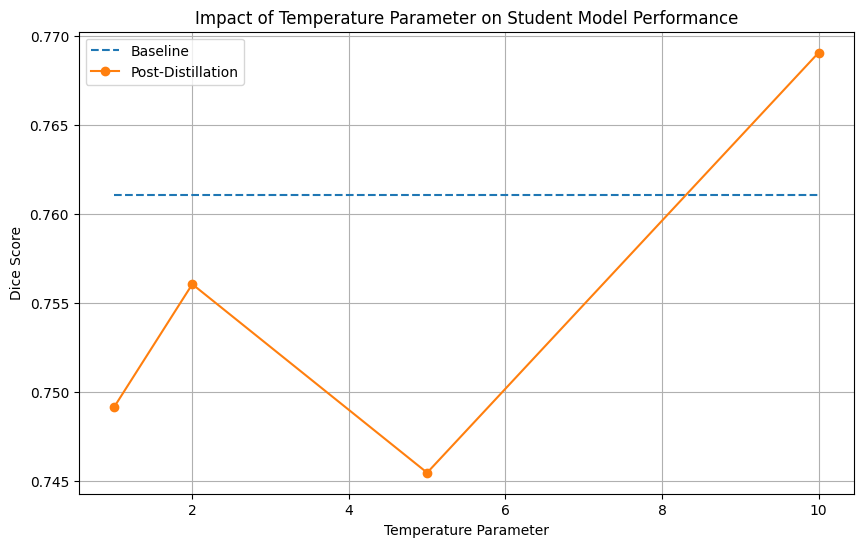

In [ ]:
baseline_score = test_model(student, val_loader, plot_=False)
print('Student score before distillation:', baseline_score)

temperature_params = [1, 2, 5, 10]
post_distillation_scores = []

for T in temperature_params:
    # Copy the original student model to preserve its pre-distilled state
    student_copy = copy.deepcopy(student)

    # Perform distillation
    distillation(teacher, student_copy, train_loader, epochs=20, lr=0.01, T=T, soft_loss_weight=0.25, bce_loss_weight=0.75, device=device, disp= False)

    # Post-distillation evaluation
    score = test_model(student_copy, val_loader, plot_=False)
    post_distillation_scores.append(score)

    print(f"Temperature: {T}, Validation Score: {score}")

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(temperature_params, [baseline_score] * len(temperature_params), label='Baseline', linestyle='--')
plt.plot(temperature_params, post_distillation_scores, label='Post-Distillation', marker='o')
plt.xlabel('Temperature Parameter')
plt.ylabel('Dice Score')
plt.title('Impact of Temperature Parameter on Student Model Performance')
plt.legend()
plt.grid(True)
plt.show()


For the same four values of T as previously we see that the performance did not change much overall although the best score was obtained at T=10

######### __Reduced model 3__: Reduce the number of Kernels only  #########

In [ ]:
# reduce Only kernels unet

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.doubleConvLayer= nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU( inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
        )
    def forward(self, x):
        out= self.doubleConvLayer(x)
        return out

class DownSample(nn.Module):
    """ if input is [b_size, in_channels, h, w] returns out of size [b_size, out_channel, h/2, w/2]"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.doubleConvLayer= DoubleConv(in_channels, out_channels)
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, x):
        cov= self.doubleConvLayer(x)
        out= self.maxpool(cov)
        return cov, out

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample= nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.doubleConvLayer= DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1= self.upsample(x1)
        x= torch.cat([x1, x2],1) #concat the output of the downsampler
        x=self.doubleConvLayer(x)
        return x


class My_unet4(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # down sample layer
        self.downconv1= DownSample(in_channels, 8)
        self.downconv2= DownSample(8, 16)
        self.downconv3= DownSample(16, 32)
        self.downconv4= DownSample(32, 64)
        #conv layers in botelneck
        self.bottel= DoubleConv(64 , 128)
        #upsample layers
        self.upconv1= UpSample(128, 64)
        self.upconv2= UpSample(64, 32)
        self.upconv3= UpSample(32, 16)
        self.upconv4= UpSample(16, 8)
        #last conv layer
        self.out = nn.Conv2d(in_channels= 8, out_channels=out_channels, kernel_size=1)
        self.sigmoid= nn.Sigmoid()
    def forward(self, x, T=1.):
        cov1, down1 = self.downconv1(x)
        cov2, down2 = self.downconv2(down1)
        cov3, down3 = self.downconv3(down2)
        cov4, down4 = self.downconv4(down3)
        bottleneck = self.bottel(down4)
        up1 = self.upconv1(bottleneck, cov4)
        up2 = self.upconv2(up1, cov3)
        up3 = self.upconv3(up2, cov2)
        up4 = self.upconv4(up3, cov1)
        out = self.sigmoid(self.out(up4)/T)
        # out= self.out(up4)
        return out


In [ ]:
model4= My_unet4(1,1).to(device)

In [ ]:
train_losses, val_losses, train_scores, val_scores = train_model(model4, train_loader, val_loader, device, epochs= 50)

Epoch 0/49, Train Loss: 0.1315420846055661, Train Score: 0.32404190115630627, Val Loss: 5.1815233732524675, Val Score: 0.6595555104707417
Epoch 1/49, Train Loss: 0.10504222874130521, Train Score: 0.4271524479346616, Val Loss: 4.133485492907073, Val Score: 0.733186728075931
Epoch 2/49, Train Loss: 0.09352338593453169, Train Score: 0.4622212898518358, Val Loss: 4.011816727487664, Val Score: 0.7611126617381447
Epoch 3/49, Train Loss: 0.08920153084078006, Train Score: 0.47713414526411463, Val Loss: 4.282539769222862, Val Score: 0.726022974440926
Epoch 4/49, Train Loss: 0.08387296926230192, Train Score: 0.49353328187550816, Val Loss: 7.660393965871711, Val Score: 0.4408998505065316
Epoch 5/49, Train Loss: 0.08090433411832366, Train Score: 0.5020429641008377, Val Loss: 5.406429893092105, Val Score: 0.6432441661232396
Epoch 6/49, Train Loss: 0.07894146269453424, Train Score: 0.5105784588626453, Val Loss: 4.588076942845395, Val Score: 0.6967963795912894
Epoch 7/49, Train Loss: 0.07639179897627

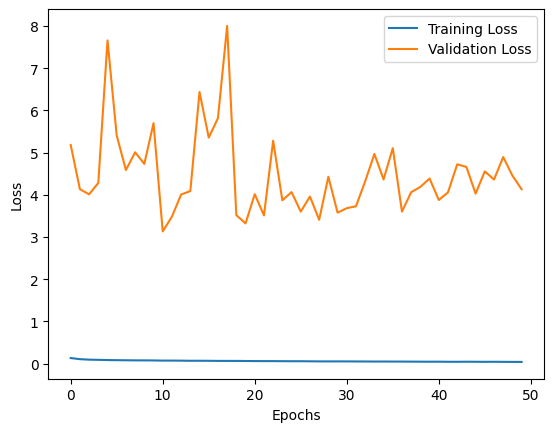

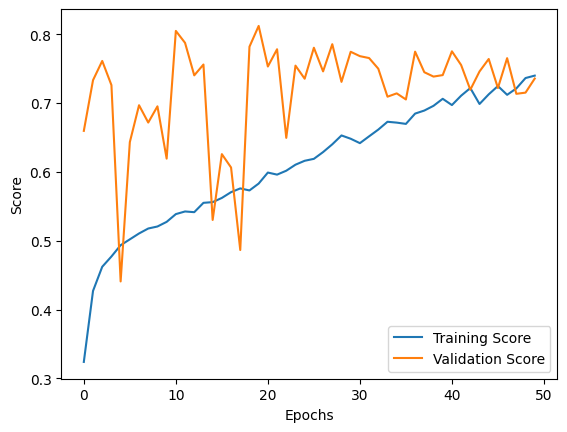

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Similarly for the scores:
plt.plot(train_scores, label='Training Score')
plt.plot(val_scores, label='Validation Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()

In [ ]:
#save model
save_path= '/content/drive/MyDrive/Geosciences/save/models/trained_unet_small_kernels.pth'
torch.save(model4.state_dict(), save_path)

b.	Implement knowledge distillation and tune the temperature parameter for the various small models.

In [ ]:
teacher=My_unet(1,1)
state= torch.load('/content/drive/MyDrive/Geosciences/save/models/trained_unet_84.pth') #map_location=torch.device('cpu')
teacher.load_state_dict(state)
teacher= teacher.to(device)


student= My_unet4(1,1)
state_student= torch.load('/content/drive/MyDrive/Geosciences/save/models/trained_unet_small_kernels.pth')
student.load_state_dict(state_student)
student= student.to(device)

100%|██████████| 19/19 [00:00<00:00, 143.86it/s]


Student score before distillation: 0.7341946426190828


100%|██████████| 19/19 [00:00<00:00, 229.11it/s]


Temperature: 1, Validation Score: 0.7481826543807983


100%|██████████| 19/19 [00:00<00:00, 225.89it/s]


Temperature: 2, Validation Score: 0.7487179197763142


100%|██████████| 19/19 [00:00<00:00, 156.61it/s]


Temperature: 5, Validation Score: 0.760805042166459


100%|██████████| 19/19 [00:00<00:00, 226.48it/s]


Temperature: 10, Validation Score: 0.758034819050839


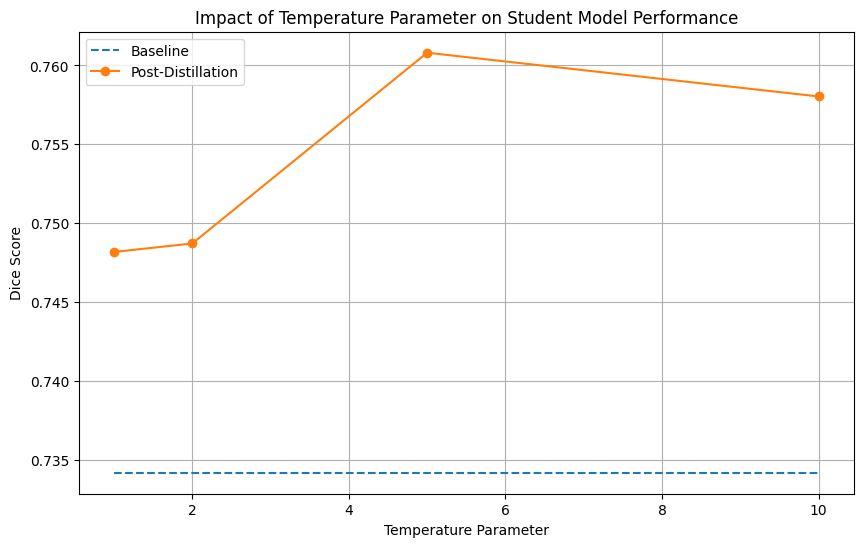

In [ ]:
baseline_score = test_model(student, val_loader, plot_=False)
print('Student score before distillation:', baseline_score)

temperature_params = [1, 2, 5, 10]
post_distillation_scores = []

for T in temperature_params:
    # Copy the original student model to preserve its pre-distilled state
    student_copy = copy.deepcopy(student)

    # Perform distillation
    distillation(teacher, student_copy, train_loader, epochs=20, lr=0.01, T=T, soft_loss_weight=0.25, bce_loss_weight=0.75, device=device, disp= False)

    # Post-distillation evaluation
    score = test_model(student_copy, val_loader, plot_=False)
    post_distillation_scores.append(score)

    print(f"Temperature: {T}, Validation Score: {score}")

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(temperature_params, [baseline_score] * len(temperature_params), label='Baseline', linestyle='--')
plt.plot(temperature_params, post_distillation_scores, label='Post-Distillation', marker='o')
plt.xlabel('Temperature Parameter')
plt.ylabel('Dice Score')
plt.title('Impact of Temperature Parameter on Student Model Performance')
plt.legend()
plt.grid(True)
plt.show()


as before the perfomance did not change much although it atteined its best at T= 5

## __3. Model Compression via Quantization :__

Static quantization was manually performed on the Unet. The process involved:

* Looping through the model's weights to identify the minimum and maximum values.
* Quantizing the weights into 8 and 16 bits.
* Storing the quantized weights.


Following quantization, the models were dequantized and evaluated to determine the impact on performance.

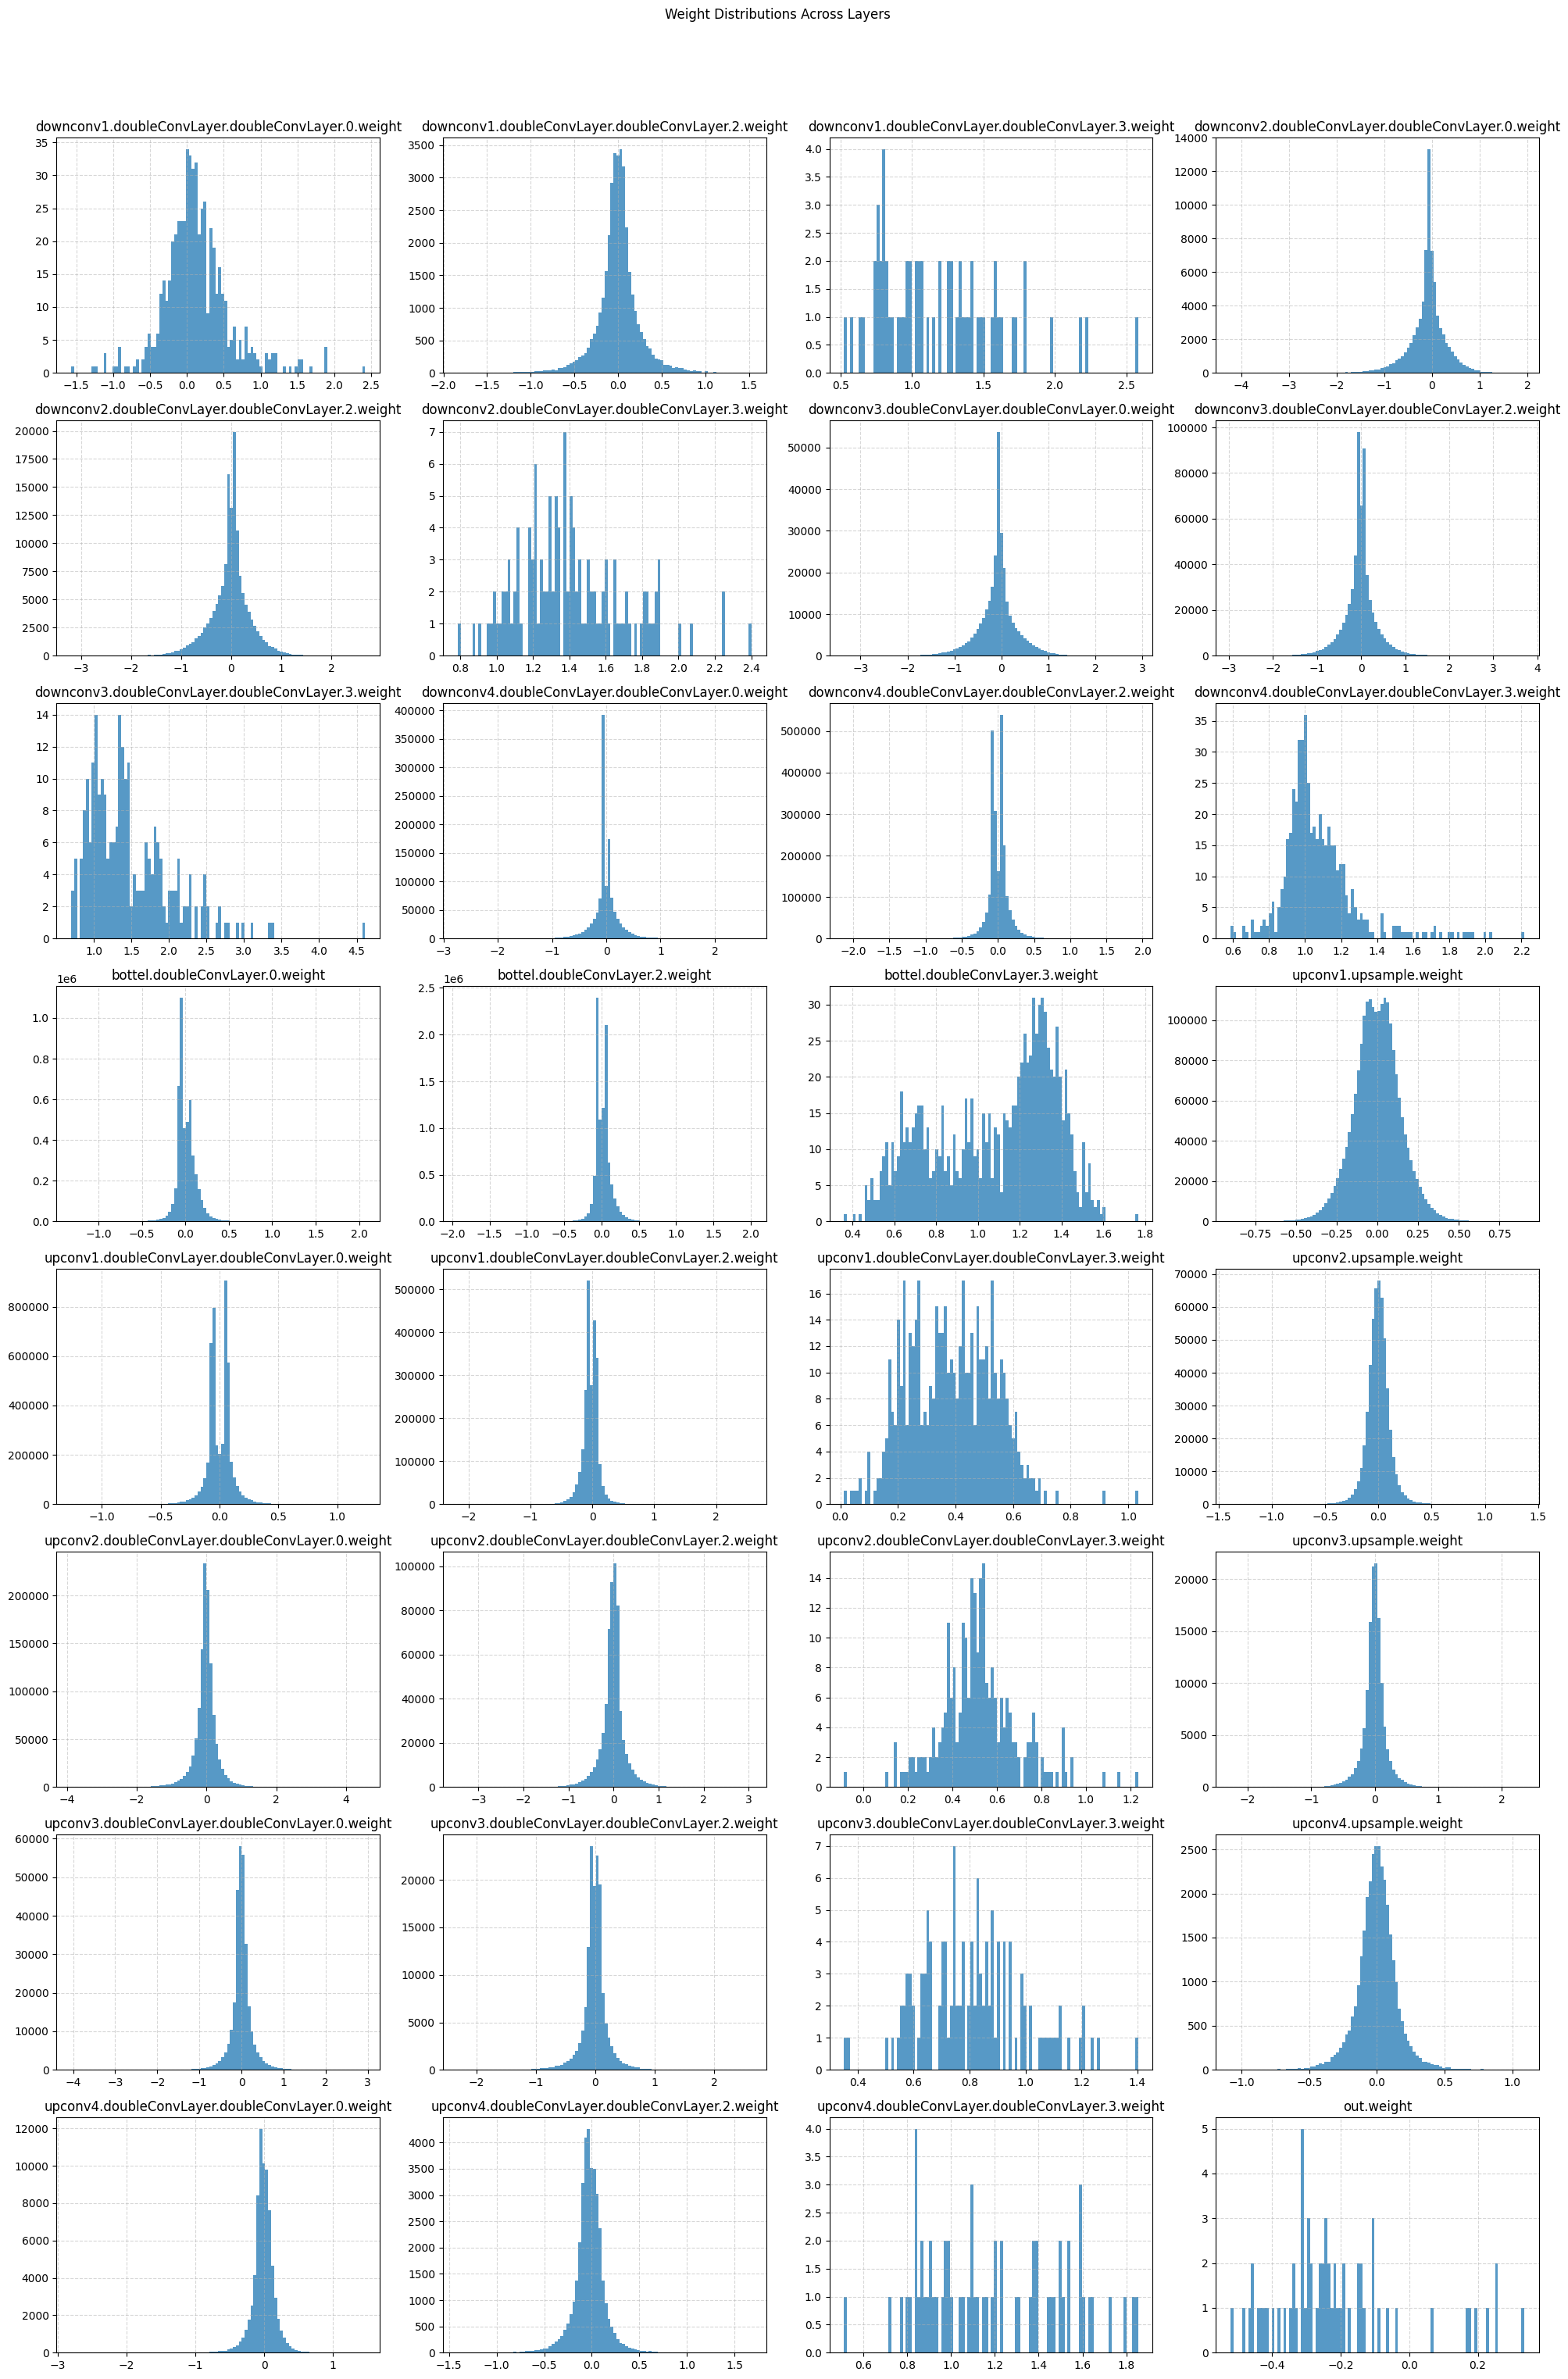

In [ ]:
visualize_weights(model)

we see that in general the weights are represented as gaussian distributions centered at zero

In [ ]:
def quantize_weights(weight, bits):
    assert bits in [16, 8], "Only 16-bit and 8-bit quantization are supported."

    min_val, max_val = weight.min(), weight.max()
    q_min, q_max = 0, 2.**bits - 1

    scale = (max_val - min_val) / (2.**bits - 1)
    zero_point = q_min - min_val / scale

    q_x =  weight / scale - zero_point
    q_x.clamp_(q_min, q_max)

    if bits ==8:
        q_x = torch.round(q_x).to(torch.uint8)
    elif bits == 16:
        q_x = torch.round(q_x).to(torch.int16)
    else:
      print('not support nb of bits')
    return q_x, scale, zero_point


def dequantize_weights(q_x, scale, zero_point):
    q_x= q_x.float() - torch.mean(q_x.float())
    return scale * (q_x.float() + zero_point)

def quantize_model(model, bits=8):
    quantized_params = {}
    quantized_weights={}
    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'weight' in name or 'bias' in name:
                quantized_weight, scale, zero_point = quantize_weights(param.data, bits= bits)
                quantized_weights[name]= quantized_weight
                quantized_params[name] = {
                    'scale': scale,
                    'zero_point': zero_point
                }
    return quantized_weights, quantized_params

def dequantize_model(model,quantized_weights, quantized_params):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if name in quantized_params:
                # Dequantize the weight
                q_info = quantized_params[name]
                dequantized_weight = dequantize_weights(quantized_weights[name], q_info['scale'], q_info['zero_point'])
                # print('\n\n\n ########## dequantized wieght   ############### \n', dequantized_weight)
                param.data= dequantized_weight
    return model

quantUnet Model Size: 29.62 MB
dequant Unet Model Size: 118.45 MB


100%|██████████| 19/19 [01:37<00:00,  5.11s/it]


7.434394348437261e-05

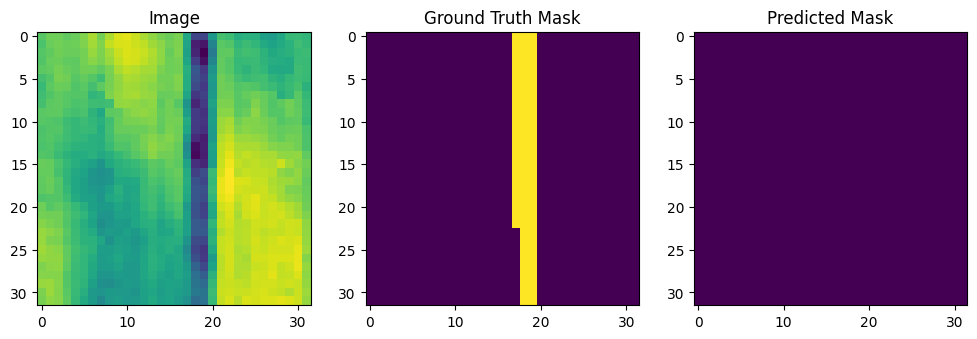

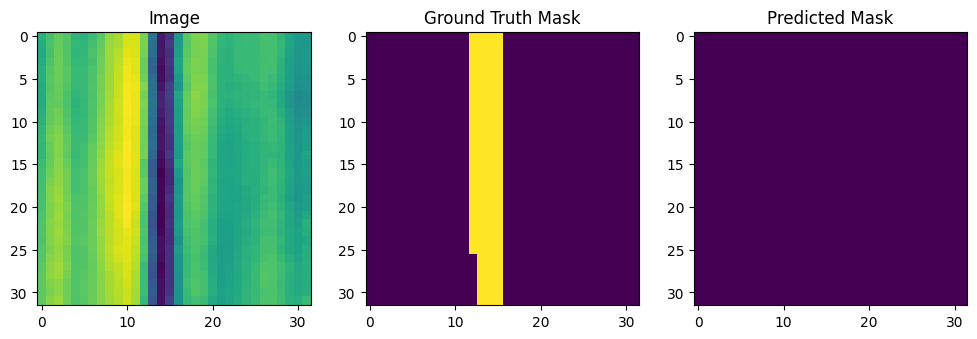

In [ ]:
quantized_weights, quantized_params = quantize_model(model, bits=  8 )
torch.save(quantized_params, '/content/drive/MyDrive/Geosciences/save/models/quantized_model_params_8.pth')
torch.save(quantized_weights, '/content/drive/MyDrive/Geosciences/save/models/quantized_model_weights_8.pth')




reduced_size = os.path.getsize('/content/drive/MyDrive/Geosciences/save/models/quantized_model_weights_8.pth')
print(f"quantUnet Model Size: {reduced_size / (1024 * 1024):.2f} MB")



deq_model= My_unet(1,1).to(device)
quantized_params = torch.load('/content/drive/MyDrive/Geosciences/save/models/quantized_model_params_8.pth')
quantized_weights = torch.load('/content/drive/MyDrive/Geosciences/save/models/quantized_model_weights_8.pth')

deq_model= dequantize_model(deq_model,quantized_weights, quantized_params)


torch.save(deq_model.state_dict(), '/content/drive/MyDrive/Geosciences/save/models/dequantized_model_params_8.pth')
reduced_size = os.path.getsize('/content/drive/MyDrive/Geosciences/save/models/dequantized_model_params_8.pth')
print(f"dequant Unet Model Size: {reduced_size / (1024 * 1024):.2f} MB")

test_model(deq_model, val_loader)

the size of the model has been reduced by a factor of 4, but as a drowback the performance is very bad

quantUnet Model Size: 59.22 MB
dequant Unet Model Size: 118.45 MB


100%|██████████| 19/19 [00:01<00:00, 13.95it/s]


0.07501780477009322

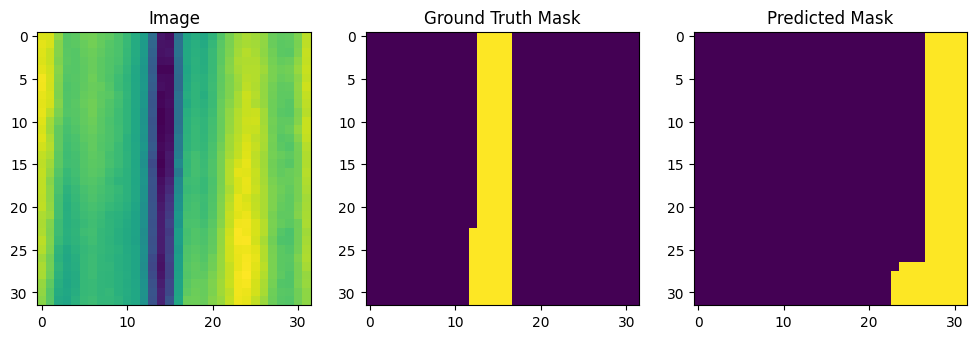

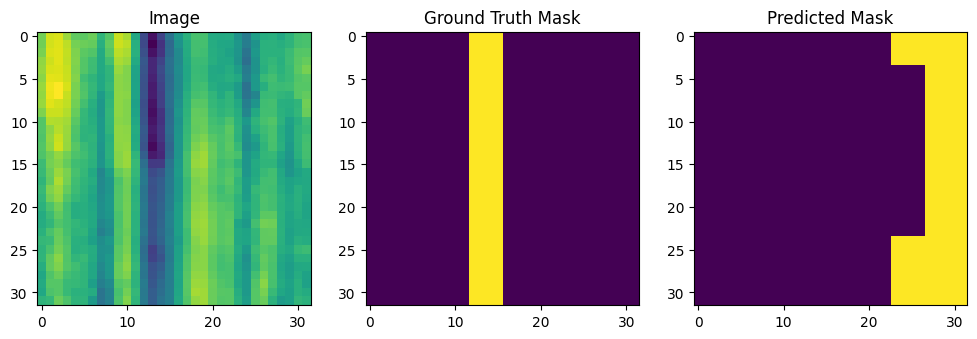

In [ ]:
quantized_weights, quantized_params = quantize_model(model, bits=  16 )
torch.save(quantized_params, '/content/drive/MyDrive/Geosciences/save/models/quantized_model_params_16.pth')
torch.save(quantized_weights, '/content/drive/MyDrive/Geosciences/save/models/quantized_model_weights_16.pth')




reduced_size = os.path.getsize('/content/drive/MyDrive/Geosciences/save/models/quantized_model_weights_16.pth')
print(f"quantUnet Model Size: {reduced_size / (1024 * 1024):.2f} MB")



deq_model= My_unet(1,1).to(device)
quantized_params = torch.load('/content/drive/MyDrive/Geosciences/save/models/quantized_model_params_16.pth')
quantized_weights = torch.load('/content/drive/MyDrive/Geosciences/save/models/quantized_model_weights_16.pth')

deq_model= dequantize_model(deq_model,quantized_weights, quantized_params)


torch.save(deq_model.state_dict(), '/content/drive/MyDrive/Geosciences/save/models/dequantized_model_params_16.pth')
reduced_size = os.path.getsize('/content/drive/MyDrive/Geosciences/save/models/dequantized_model_params_16.pth')
print(f"dequant Unet Model Size: {reduced_size / (1024 * 1024):.2f} MB")

test_model(deq_model, val_loader)

We see that, although the size of the model has been reduced by half,  the performance is very bad.

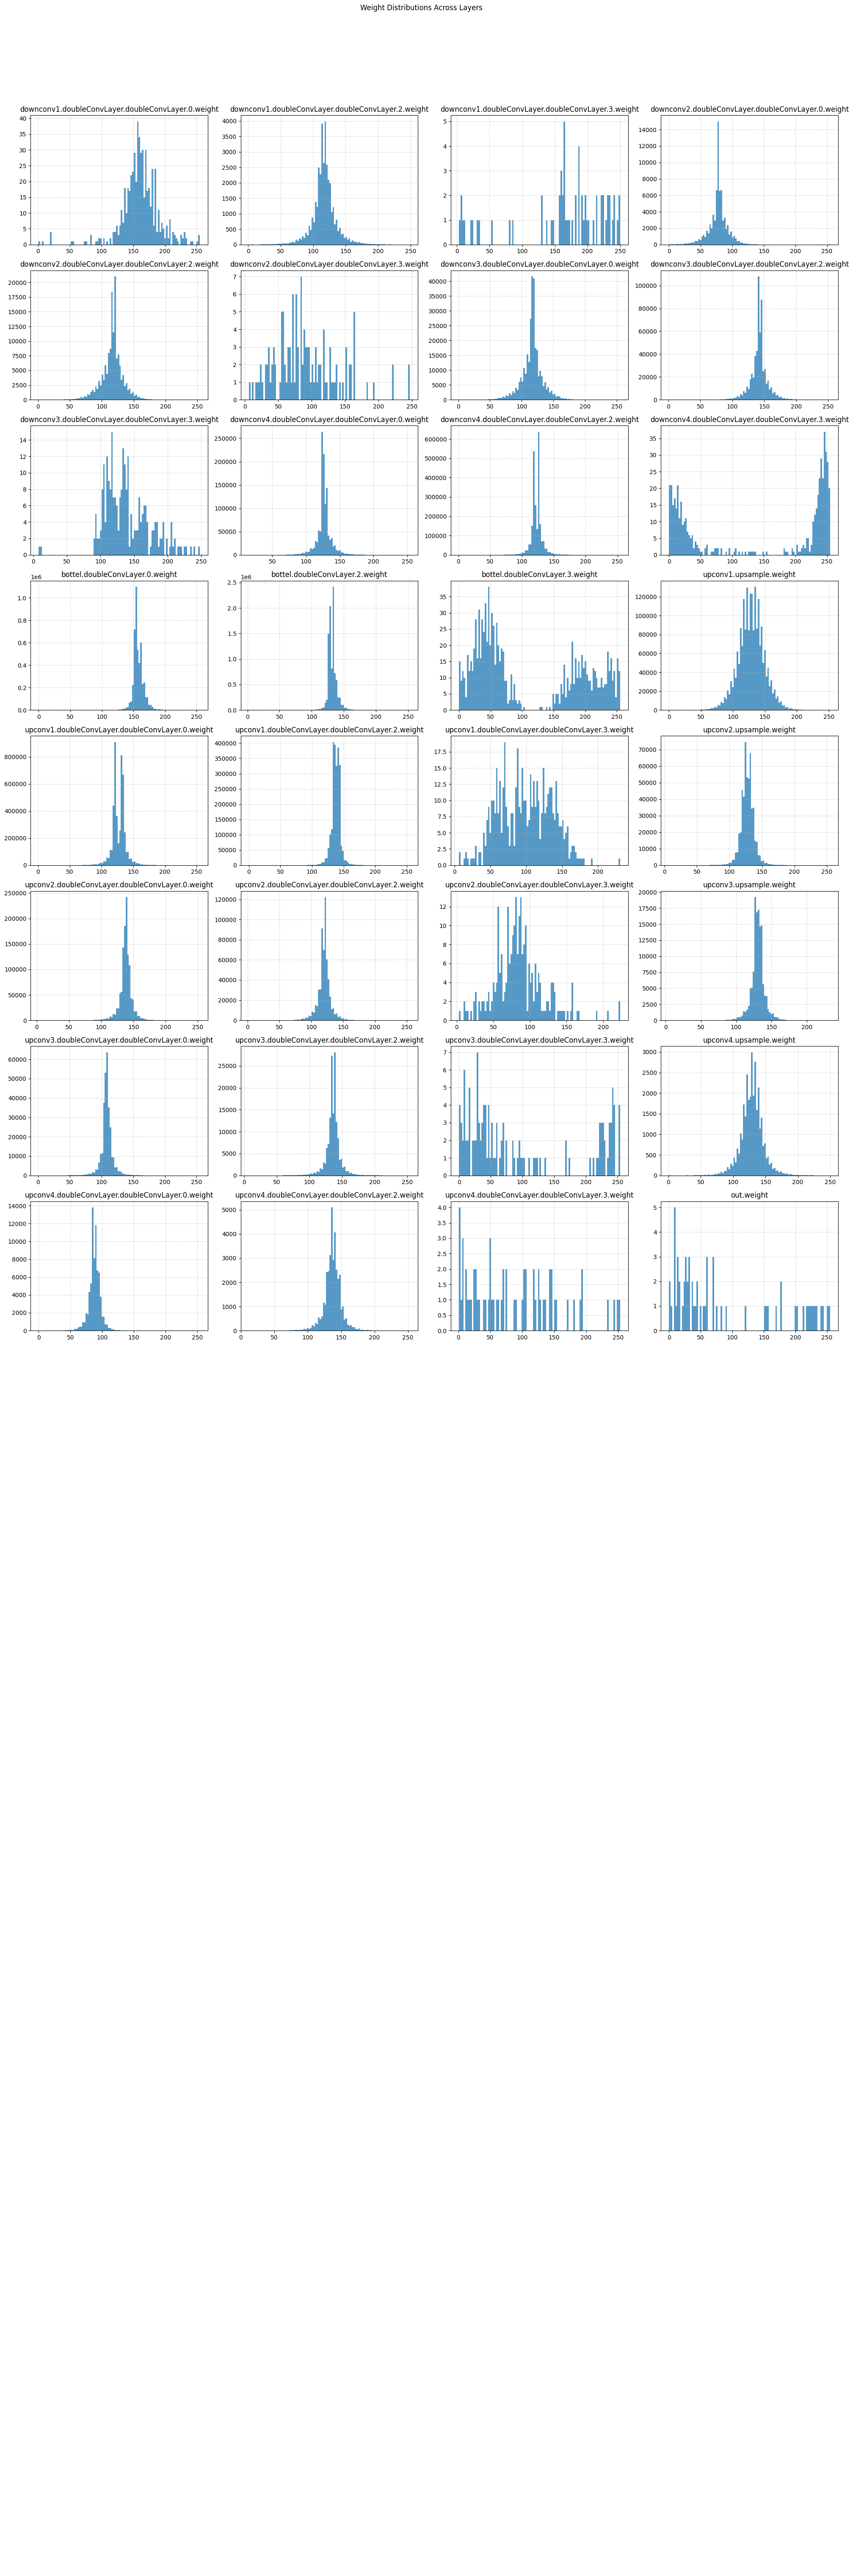

In [ ]:
visualize_weights(quantized_weights, weights=True)

__Knowledge Distillation Post-Quantization__

Knowledge distillation was again utilized, this time to transfer knowledge from the original model to the dequantized 8-bit model. This step aimed to recover any performance losses incurred through quantization.

In [ ]:
teacher=My_unet(1,1)
state= torch.load('/content/drive/MyDrive/Geosciences/save/models/trained_unet_84.pth') #map_location=torch.device('cpu')
teacher.load_state_dict(state)
teacher= teacher.to(device)


student=My_unet(1,1)
state= torch.load('/content/drive/MyDrive/Geosciences/save/models/dequantized_model_params_8.pth')
student.load_state_dict(state)
student= student.to(device)

100%|██████████| 19/19 [00:01<00:00, 15.53it/s]


Student score before distillation: 0.12281678734641326


100%|██████████| 19/19 [00:00<00:00, 19.77it/s]


Temperature: 1, Validation Score: 0.12425304047371212


100%|██████████| 19/19 [00:00<00:00, 20.94it/s]


Temperature: 2, Validation Score: 0.12404696839420419


100%|██████████| 19/19 [00:00<00:00, 21.08it/s]


Temperature: 5, Validation Score: 0.12320021500712947


100%|██████████| 19/19 [00:00<00:00, 21.10it/s]


Temperature: 10, Validation Score: 0.12301204902561087


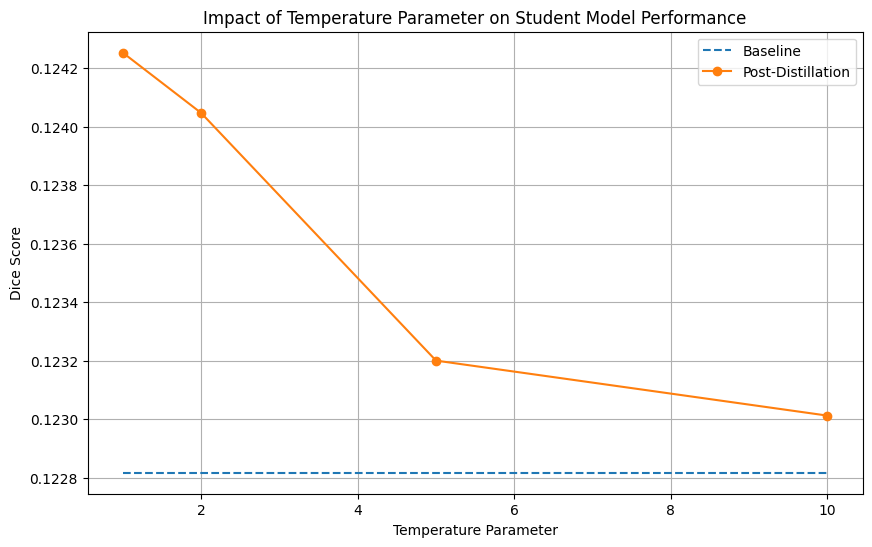

In [ ]:
import copy
baseline_score = test_model(student, val_loader, plot_=False, distillation= True)
print('Student score before distillation:', baseline_score)

temperature_params = [1, 2, 5, 10]

for T in temperature_params:
    # Copy the original student model to preserve its pre-distilled state
    student_copy = copy.deepcopy(student)

    # Perform distillation
    # distillation(teacher, student_copy, train_loader, epochs=20, lr=0.01, T=T, soft_loss_weight=0.25, bce_loss_weight=0.75, device=device, disp= False)
    # Post-distillation evaluation
    score = test_model(student_copy, val_loader, plot_=False, distillation= True)
    post_distillation_scores.append(score)

    print(f"Temperature: {T}, Validation Score: {score}")

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(temperature_params, [baseline_score] * len(temperature_params), label='Baseline', linestyle='--')
plt.plot(temperature_params, post_distillation_scores, label='Post-Distillation', marker='o')
plt.xlabel('Temperature Parameter')
plt.ylabel('Dice Score')
plt.title('Impact of Temperature Parameter on Student Model Performance')
plt.legend()
plt.grid(True)
plt.show()



We observe that despite efforts in knowledge distillation, the model struggled to learn from the teacher model, showing no significant improvement in performance across various temperature values. This challenge may stem from the dequantization process of the 8-bit model back to the float-32 format, introducing excessive uncertainty. In future endeavors, to mitigate these limitations and enhance model efficiency, we plan to explore more sophisticated quantization techniques. Among the promising methods are dynamic quantization, which adjusts quantization parameters dynamically during model inference, and mixed precision training, where certain parts of the model utilize lower precision computations for efficiency while maintaining high precision where needed for accuracy. Additionally, quantization-aware training (QAT) will be considered, where the model is trained to be aware of the quantization errors, potentially leading to improved resilience against information loss during quantization. Each of these methods offers a nuanced approach to balancing model size, computational efficiency, and performance, promising avenues for further research and application.